In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import seaborn as sns
import pandas as pd
import numpy as np
import json
import glob
import re
import matplotlib.pyplot as plt
import math
import tqdm

In [2]:
async_folder = "logs/08_E"
sync_folder = "logs/09_F"

experiment_phases = [0, 600_000, 1_200_000, 1_800_000]
function_colors = {
    "check": "blue",
    "virus": "orange",
    "ocr": "green",
    "email": "red",
    "urgentcheck": "blue",
    "urgentvirus": "orange",
    "urgentocr": "green",
    "urgentemail": "red"
}
cpu_color = "black"


In [3]:

min_timestamp = 9223372036854775807 # Too big, please don't run after Tue Oct 07 4892 21:52:48 GMT+0000
last_experiment_timestamp = 0 # Please don't run this experiment before Thu Jan 01 1970 00:00:00 GMT+0000
def get_df_from_folder(folder):
    global min_timestamp
    global last_experiment_timestamp
    lines = []
    for file_name in glob.glob("*.log", root_dir=folder):
        with open(folder + "/" + file_name) as f:
            while line := f.readline():
                if "PFSTT" in line and "dashboard is deleting returned header" not in line:
                    json_string = re.search(r'PFSTT(.*?)TTSFP', line).group(1)
                    try:
                        lines.append(json.loads(json_string))
                    except:
                        print("Error in file: " + file_name)
                        print("Line: " + line)
                        print("JSON: " + json_string)
                        print("-----")
                        continue

    df = pd.DataFrame(lines)
    # Set Data Types
    df["start"] = df["start"].astype(float)
    df["end"] = df["end"].astype(float)
    df["request_timestamp"] = df["request_timestamp"].astype(float)
    df["request_deadline"] = df["request_deadline"].astype(float)

    # Calculate Durations
    cut_off_after_cpu_load = True
    if cut_off_after_cpu_load:
        max_start_time = df["start"] + experiment_phases[3]
        df = df[df["start"] < max_start_time]

    last_experiment_timestamp = max(last_experiment_timestamp, df["end"].max())
    min_unix_time = df["start"].min()
    min_timestamp = min(min_timestamp, df["start"].min())

    df["request_timestamp"] = df["request_timestamp"] - min_timestamp
    df["request_deadline"] = df["request_deadline"] - min_timestamp
    df["start"] = df["start"] - min_timestamp
    df["end"] = df["end"] - min_timestamp

    # Add new columns
    df["run_duration"] = df["end"] - df["start"]
    df["time_to_deadline"] = df["request_deadline"] - df["start"]
    df["init_duration"] = df["start"] - df["request_timestamp"]
    df = df.sort_values(by=["function", "start"])
    df["start_diff"] = df.groupby("function")["start"].diff()
    df['line_segment'] = (df['start_diff'] > 5000).cumsum() # create a new line segment if there is a 5 second break
    return (df, min_unix_time)

(sync_df, sync_min_unix) = get_df_from_folder(sync_folder)
(async_df, async_min_unix) = get_df_from_folder(async_folder)

In [4]:
# If you want all CPU usage values in the df set this to False
ONLY_RELEVANT_CPU = True

smaller_dfs = []
for file_name in glob.glob("*.csv", root_dir="usage/"):
    # if ONLY_RELEVANT_CPU:
    #     start_ts = int(file_name.split("_")[3].split(".")[0])
    #     if start_ts > last_experiment_timestamp or start_ts < min_timestamp - 1000*60*60*24:
    #         continue
    with open("usage/" + file_name) as f:
        smaller_dfs.append(pd.read_csv(f))
usage_df = pd.concat(smaller_dfs)
# usage_df["experiment_time"] = usage_df["unix_time"] - min_timestamp

# if ONLY_RELEVANT_CPU:
#     # Delete all values 10 seconds after the last call ended and 10 seconds before the first call started
#     print("removed before:" + str(len(usage_df[usage_df["unix_time"] <= (last_experiment_timestamp)])))
#     usage_df = usage_df[usage_df["unix_time"] <= (last_experiment_timestamp)]
#     print("removed after:" + str(len(usage_df[usage_df["unix_time"] >= (min_timestamp)])))
#     usage_df = usage_df[usage_df["unix_time"] >= (min_timestamp)]

async_usage_df = usage_df[(usage_df["unix_time"] > async_min_unix) & (usage_df["unix_time"] < async_min_unix + async_df["end"].max())]
async_usage_df["experiment_time"] = async_usage_df["unix_time"] - async_min_unix
sync_usage_df = usage_df[(usage_df["unix_time"] > sync_min_unix) & (usage_df["unix_time"] < sync_min_unix + sync_df["end"].max())]
sync_usage_df["experiment_time"] = sync_usage_df["unix_time"] - sync_min_unix

/tmp/ipykernel_82924/2924781667.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  async_usage_df["experiment_time"] = async_usage_df["unix_time"] - async_min_unix
/tmp/ipykernel_82924/2924781667.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sync_usage_df["experiment_time"] = sync_usage_df["unix_time"] - sync_min_unix


In [5]:
def get_workflow_from_df(df):
    df = df.copy()
    # set arbitrary_start to request_timestamp if it is set, use it. otherwise, set it to start
    df["arbitrary_start"] = df["request_timestamp"]
    df["arbitrary_start"].fillna(df["start"])
    df["total_run_duration"] = df["end"] - df["arbitrary_start"]
    worfklow_list = []
    for id in df["callid"].unique():
        workflow_info = {
            'start': df[df["callid"] == id]["start"].min(),
            'end': df[df["callid"] == id]["end"].max(),
            'num_swamped': len(df[(df["callid"] == id) & df["mode"] == "swamped"]),
            'run_duration': df[df["callid"] == id]["run_duration"].sum(),
            'total_run_duration': df[df["callid"] == id]["total_run_duration"].sum(),
        }
        worfklow_list.append(workflow_info)

    return pd.DataFrame(worfklow_list)
sync_workflow_df = get_workflow_from_df(sync_df)
async_workflow_df = get_workflow_from_df(async_df)

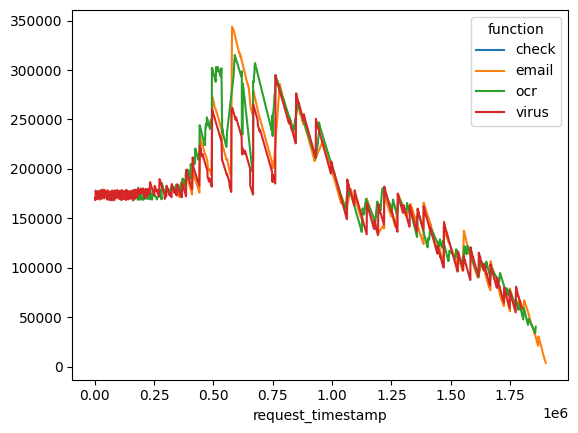

<Axes: xlabel='request_timestamp'>

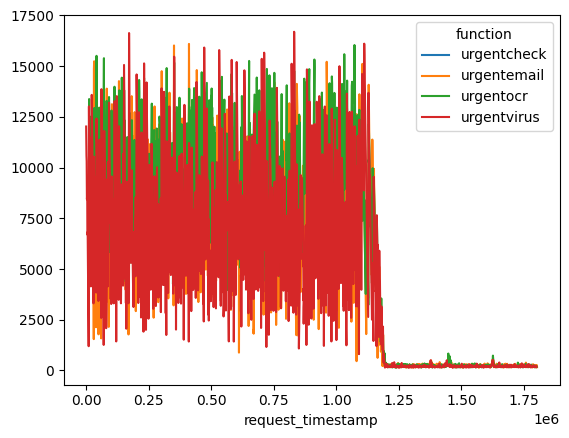

In [7]:
sns.lineplot(data=async_df, x="request_timestamp", y=async_df["start"]-async_df["request_timestamp"], hue="function")
plt.show()
sns.lineplot(data=sync_df, x="request_timestamp", y=sync_df["start"]-sync_df["request_timestamp"], hue="function")

<Axes: xlabel='experiment_time', ylabel='cpu_percent'>

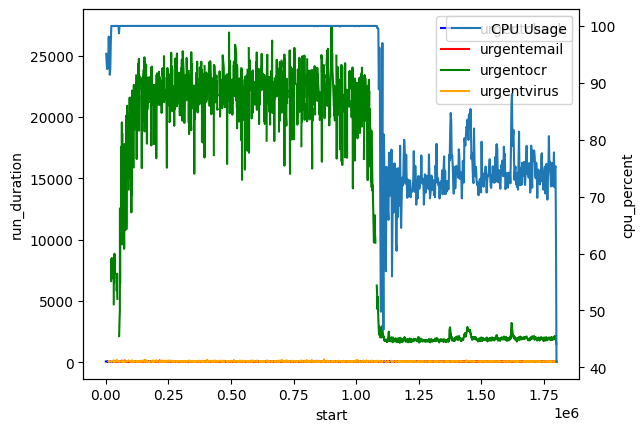

In [8]:

for (function, segment), group in sync_df.groupby(["function", "line_segment"]):
    sns.lineplot(data=group, x="start", y="run_duration", color=function_colors[function], errorbar="ci", label=function, legend="brief")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
ax2 = plt.twinx()
sns.lineplot(ax=ax2, data=sync_usage_df, x="experiment_time", y="cpu_percent", label="CPU Usage")

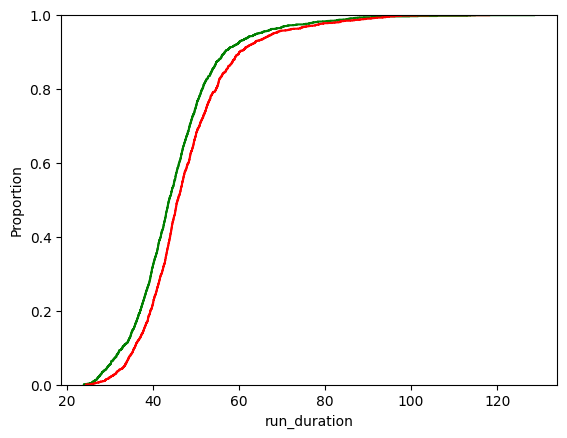

<Axes: xlabel='run_duration', ylabel='Proportion'>

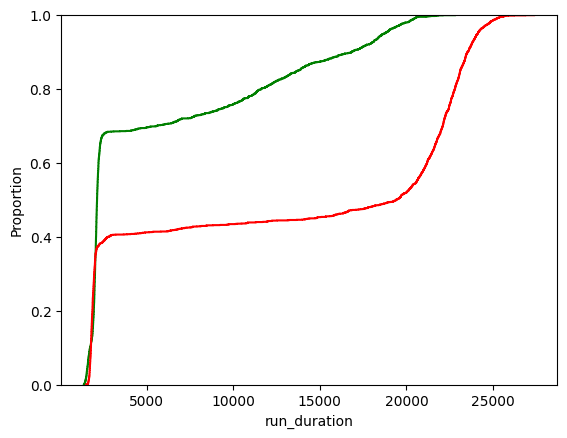

In [9]:
sns.ecdfplot(data=async_df[async_df["function"] == "check"], x="run_duration", color="green", label="Async")
sns.ecdfplot(data=sync_df[sync_df["function"] == "urgentcheck"], x="run_duration", color="red", label="Sync")
plt.show()
sns.ecdfplot(data=async_df[async_df["function"] == "ocr"], x="run_duration", color="green", label="Async")
sns.ecdfplot(data=sync_df[sync_df["function"] == "urgentocr"], x="run_duration", color="red", label="Sync")

<Axes: >

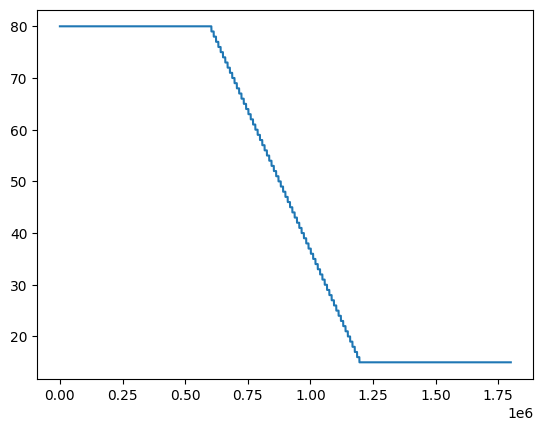

In [ ]:
def get_cpu_share(start, end, current):
    # get the length of the experiment
    length = end - start
    # get the current time in the experiment
    current = current - start

    # if the current time is in the first third of the experiment
    if current < length/3:
        return "0.80"
    # if the current time is in the last third of the experiment
    elif current > 2*length/3:
        return "0.15"
    # if the current time is in the middle third of the experiment
    else:
        # calculate the cpu share based on the current time
        return str(round(((-1.95/length)*current + 1.45), 2))
        # the value if you want to go from 50 to 15:
        # return str(round(((-105/length)*current + 85)/100, 2))

artificial_cpu_load = [float(get_cpu_share(start, end, i)) * 100 for i in range(start, end)]
sns.lineplot(artificial_cpu_load)

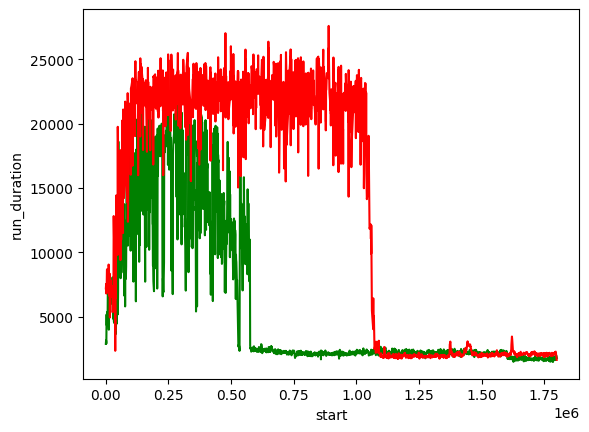

<Axes: xlabel='run_duration', ylabel='Proportion'>

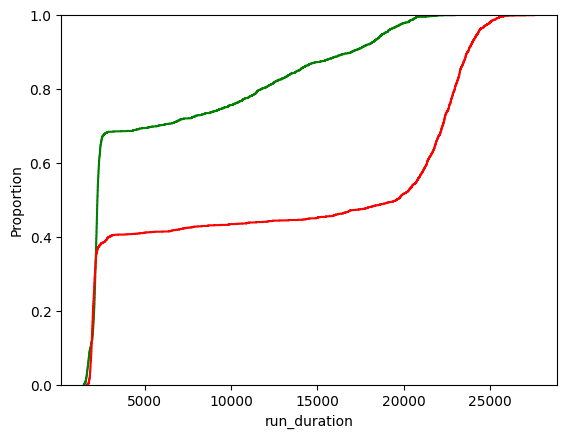

In [10]:
sns.lineplot(data=async_workflow_df, x="start", y="run_duration", color="green")
sns.lineplot(data=sync_workflow_df, x="start", y="run_duration", color="red")
plt.show()
sns.ecdfplot(data=async_workflow_df, x="run_duration", color="green")
sns.ecdfplot(data=sync_workflow_df, x="run_duration", color="red")

In [11]:
# I need a list of how many requests are running (time is between start and end) for every ten seconds of the experiment
async_concurrent_requests = [(len(async_df[(async_df["start"] <= i) & (async_df["end"] >= i)])) for i in tqdm.trange(int(async_df["start"].min()), int(async_df["end"].max()), 10_000)]
sync_concurrent_requests = [(len(sync_df[(sync_df["start"] <= i) & (sync_df["end"] >= i)])) for i in tqdm.trange(int(sync_df["start"].min()), int(sync_df["end"].max()), 10_000)]

  0%|          | 0/191 [00:00<?, ?it/s]

100%|██████████| 181/181 [00:00<00:00, 4654.20it/s]


<Axes: >

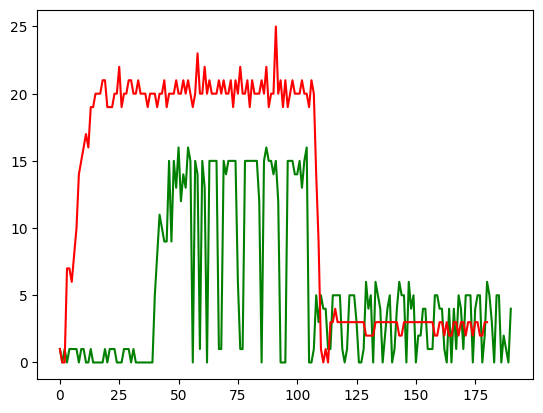

In [12]:
sns.lineplot(async_concurrent_requests, color="green")
sns.lineplot(sync_concurrent_requests, color="red")

# Actual Paper Grpfash

(0.0, 1800000.0)

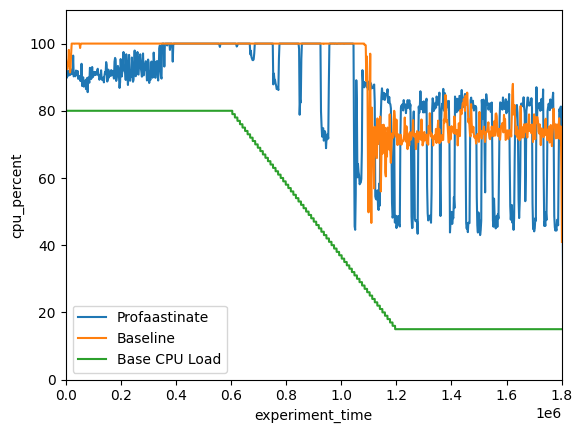

In [ ]:
sns.lineplot(data=async_usage_df, x="experiment_time", y="cpu_percent", label="Profaastinate")
sns.lineplot(data=sync_usage_df, x="experiment_time", y="cpu_percent", label="Baseline")
sns.lineplot(data=artificial_cpu_load, label="Base CPU Load")
plt.ylim(0, 110)
plt.xlim(0, experiment_phases[3])